# Feedforward classification of the NMIST data
### Advanced Deep Learning 2023
This notebook was written originally Jon Sporring (mailto:sporring@di.ku.dk) and heavily inspired by https://clay-atlas.com/us/blog/2021/04/22/pytorch-en-tutorial-4-train-a-model-to-classify-mnist.

We consider the Modified National Institute of Standards and Technology database of handwritten digits (MNIST): http://yann.lecun.com/exdb/mnist/

## Installs

On non-colab system, is usually good to make an environment and install necessary tools there. E.g., anaconda->jupyter->terminal create an environment, if you have not already, and activate it:
```
conda create -n adl python=3.9
conda activate adl
```
then install missing packages such as:
```
conda install ipykernel torch matplotlib torchmetrics scikit-image jpeg
conda install -c conda-forge segmentation-models-pytorch ipywidgets
```
and if you want to add it to jupyter's drop-down menu
```
ipython kernel install --user --name=adl
```
Now reload the jupyter-notebook's homepage and make a new or load an existing file. On colab, the tools have to be installed everytime

In [ ]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=9d92865feabb9c722aed6ab57a04227f0934ffbdca412a6a25f73c9d86c051cb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=99c8949aaa13f4ddea97b0f5b

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Set global device 

In [ ]:
# GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("GPU State:", device)

GPU State: cuda:0


## Functions

In [ ]:
def training_loop(
    model, loss, optimizer, train_Loader, n_epochs, verbose=True, device=device
):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    """

    # Train
    for epoch in range(epochs):
        running_loss = 0.0

        for times, data in enumerate(train_Loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            # print("input shape", inputs.shape)
            # inputs = inputs.view(inputs.shape[0], -1)
            # print("input shape (2)", inputs.shape)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Foward + backward + optimize
            outputs = net(inputs)
            loss_tensor = loss(outputs, labels)
            loss_tensor.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss_tensor.item()
            if verbose:
                if times % 100 == 99 or times + 1 == len(trainLoader):
                    print(
                        "[%d/%d, %d/%d] loss: %.3f"
                        % (
                            epoch + 1,
                            epochs,
                            times + 1,
                            len(trainLoader),
                            running_loss / 2000,
                        )
                    )

In [ ]:
def evaluate_model(model, data_loader, device=device):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.

    Returns: the total number of correct classifications,
             the total number of images
             the list of the per class correct classification,
             the list of the per class total number of images.
    """

    # Test
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testLoader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]

    with torch.no_grad():
        for data in testLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    return (correct, total, class_correct, class_total)

## Main program

In [ ]:
# Transform
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
# Data
trainSet = datasets.MNIST(root="MNIST", download=True, train=True, transform=transform)
testSet = datasets.MNIST(root="MNIST", download=True, train=False, transform=transform)
trainLoader = dset.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = dset.DataLoader(testSet, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 258401148.84it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37584763.83it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 149300362.61it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5433693.32it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [ ]:
# Model
class Net(nn.Module):
    def __init__(self, cnn=False):
        super(Net, self).__init__()
        self.is_cnn = cnn
        if cnn:
            self.main = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
                nn.ReLU(),
                nn.MaxPool2d(
                    kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False
                ),
                nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)),
                nn.ReLU(),
                nn.MaxPool2d(
                    kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False
                ),
                nn.Flatten(start_dim=1, end_dim=-1),
                nn.Linear(in_features=800, out_features=10, bias=True),
                nn.LogSoftmax(dim=1),
            )

        else:
            self.main = nn.Sequential(
                nn.Linear(in_features=784, out_features=128),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=64),
                nn.ReLU(),
                nn.Linear(in_features=64, out_features=10),
                nn.LogSoftmax(dim=1),
            )

    def forward(self, input):
        if self.is_cnn:
            return self.main(input)
        else:
            return self.main(input.view(input.shape[0], -1))


fnn = Net().to(device)
print("FNN", fnn)
cnn = Net(cnn=True).to(device)
print("CNN", cnn)

FNN Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
CNN Net(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=10, bias=True)
    (8): LogSoftmax(dim=1)
  )
)


In [ ]:
for net in [cnn, fnn]:
    num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(num_params)

12810
109386


Training CNN on 60000 images
[1/4, 100/938] loss: 0.003
[1/4, 200/938] loss: 0.006
[1/4, 300/938] loss: 0.009
[1/4, 400/938] loss: 0.012
[1/4, 500/938] loss: 0.015
[1/4, 600/938] loss: 0.018
[1/4, 700/938] loss: 0.021
[1/4, 800/938] loss: 0.024
[1/4, 900/938] loss: 0.027
[1/4, 938/938] loss: 0.028
[2/4, 100/938] loss: 0.003
[2/4, 200/938] loss: 0.006
[2/4, 300/938] loss: 0.009
[2/4, 400/938] loss: 0.012
[2/4, 500/938] loss: 0.014
[2/4, 600/938] loss: 0.017
[2/4, 700/938] loss: 0.020
[2/4, 800/938] loss: 0.022
[2/4, 900/938] loss: 0.025
[2/4, 938/938] loss: 0.026
[3/4, 100/938] loss: 0.003
[3/4, 200/938] loss: 0.005
[3/4, 300/938] loss: 0.007
[3/4, 400/938] loss: 0.010
[3/4, 500/938] loss: 0.013
[3/4, 600/938] loss: 0.016
[3/4, 700/938] loss: 0.018
[3/4, 800/938] loss: 0.021
[3/4, 900/938] loss: 0.023
[3/4, 938/938] loss: 0.024
[4/4, 100/938] loss: 0.002
[4/4, 200/938] loss: 0.004
[4/4, 300/938] loss: 0.006
[4/4, 400/938] loss: 0.009
[4/4, 500/938] loss: 0.012
[4/4, 600/938] loss: 0.014

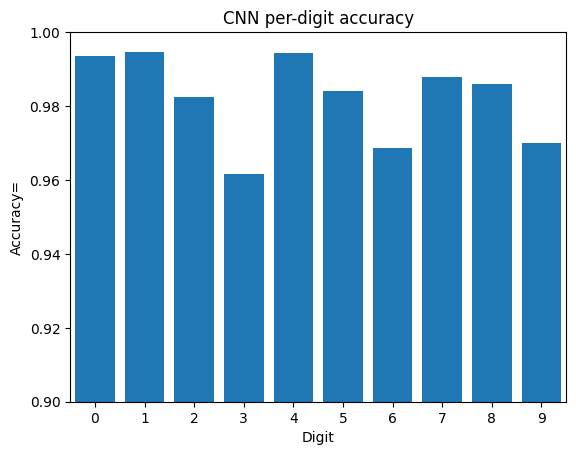

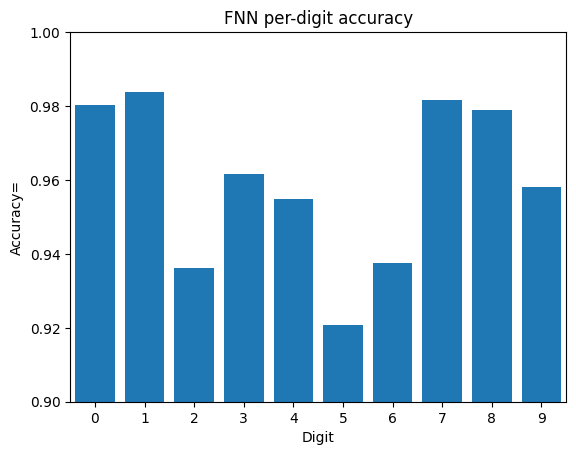

In [ ]:
res = []
for net in [cnn, fnn]:
    if net == fnn:
        name = "FNN"
    elif net == cnn:
        name = "CNN"
    else:
        raise ValueError("Unknown net")
    # Parameters
    epochs = 4
    lr = 0.002
    loss = nn.NLLLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

    # Train
    print(f"Training {name} on %d images" % trainSet.data.shape[0])
    training_loop(net, loss, optimizer, trainLoader, epochs)
    print(f"Training {name} Finished.\n")

    # Test
    correct, total, class_correct, class_total = evaluate_model(net, testLoader)
    print(
        f"Accuracy of {name} on the %d test images: %d %%"
        % (testSet.data.shape[0], (100 * correct / total))
    )
    for i in range(10):
        print("Accuracy of %d: %3f" % (i, (class_correct[i] / class_total[i])))
    
    fig = plt.figure()
    plt.bar(range(10), np.array(class_correct) / np.array(class_total))
    plt.title(f"{name} per-digit accuracy")
    plt.xlabel("Digit")
    plt.ylabel("Accuracy=")
    plt.gca().set_xticks([x for x in range(10)])
    plt.gca().set_xlim(-0.5, 9.5)
    plt.gca().set_ylim(0.9, 1.0)
    plt.savefig(f"{name}_per_digit_acc.png", dpi=300)

    res.append(np.array(class_correct) / np.array(class_total))
    print(f"{name} has {sum(p.numel() for p in net.main.parameters() if p.requires_grad)} parameters")

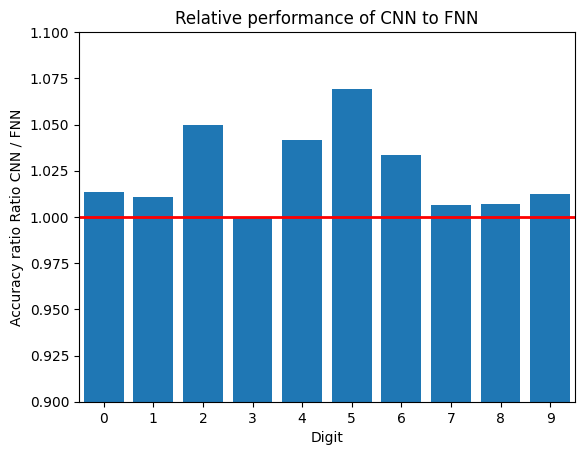

In [ ]:
fig = plt.figure()
plt.bar(range(10), res[0] / res[1])
plt.title(f"Relative performance of CNN to FNN")
plt.xlabel("Digit")
plt.ylabel("Accuracy ratio Ratio CNN / FNN")
plt.gca().set_xticks([x for x in range(10)])
plt.gca().set_xlim(-0.5, 9.5)
plt.gca().set_ylim(0.9, 1.1)
plt.hlines(y=1.0, xmin=-0.5, xmax=10, linewidth=2, color='r')
plt.savefig(f"class_correct.png", dpi=300)